# **Сегментирование клиентов онлайн-магазина подарков**

## 1. Постановка задачи


В данном проекте решим настоящую бизнес-задачу в области маркетинга. Нужно произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными предстоит работать и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


прочитаем данные:

In [2]:
data = pd.read_csv(
    "data\customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Судя по описанию задачи, данные за годовой период — проверим, так ли это.

In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [5]:
data.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829,541909
unique,25900,4070,4223,NaN,NaN,NaN,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841,United Kingdom
freq,1114,2313,2369,NaN,NaN,NaN,7983,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,NaN,NaN


In [6]:
# Посмотрим на мин. не отрицательную стоимость товара.
data[data['UnitPrice']>=0]['UnitPrice'].min()

np.float64(0.0)

Да, данные предоставлены практически за год. Видим странные значения в полях мин. кол-во товаров в заказе, мин. стоимость товара.
Видим, что 4372 уникальных клиента из 38 стран покупали товары за период выгрузки датасета.

## 3. Предобработка и очистка данных

На этом этапе подготовим датасет для дальнейшего моделирования, произведя очистку данных.


Проверим на пропуски.

In [7]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Пропуски в столбце с идентификатором клиента и описанием товара могут свидетельствовать о некорректных/незавершённых транзакциях.

In [8]:
data[data['Description'].isna()]['CustomerID'].isna().sum()

np.int64(1454)

Все поля с пропущенным описанием товаров также имеют пропуски в CustomerID.

In [9]:
data[data['CustomerID'].isna()]['InvoiceNo'].nunique()

3710

Имеем 3710 уникальных транзакций без ID клиента.

Посмотрим на статистики отмененных транзакций.

In [10]:
data[data['InvoiceNo'].str.startswith('C')].describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,9288,9288,9288,9288.000000,9288,9288.000000,8905,9288
unique,3836,1947,1972,NaN,NaN,NaN,1589,30
top,C570867,M,Manual,NaN,NaN,NaN,14911,United Kingdom
freq,101,244,244,NaN,NaN,NaN,226,7856
mean,NaN,NaN,NaN,-29.885228,2011-06-26 03:42:05.943152640,48.393661,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 09:41:00,0.010000,NaN,NaN
25%,NaN,NaN,NaN,-6.000000,2011-03-21 16:15:00,1.450000,NaN,NaN
50%,NaN,NaN,NaN,-2.000000,2011-07-07 17:33:30,2.950000,NaN,NaN
75%,NaN,NaN,NaN,-1.000000,2011-10-06 20:36:00,5.950000,NaN,NaN
max,NaN,NaN,NaN,-1.000000,2011-12-09 11:58:00,38970.000000,NaN,NaN


 В них все значения кол-ва товаров отрицательны.

In [11]:
data[~data['InvoiceNo'].str.startswith('C')].describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,532621,532621,531167,532621.000000,532621,532621.000000,397924,532621
unique,22064,4059,4207,NaN,NaN,NaN,4339,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841,United Kingdom
freq,1114,2271,2327,NaN,NaN,NaN,7847,487622
mean,NaN,NaN,NaN,10.239972,2011-07-04 17:06:10.804305920,3.847621,NaN,NaN
min,NaN,NaN,NaN,-9600.000000,2010-12-01 08:26:00,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 12:13:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-20 11:54:00,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 12:21:00,4.130000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,13541.330000,NaN,NaN


Хотя в не отменных транзакциях тоже видим отрицательные значения.

Удалим строки, содержащие пропуски в этих столбцах

In [12]:
data = data.dropna(subset=['CustomerID','Description'])
data.shape

(406829, 8)

Проверим на наличие дубликатов и удалим их.



In [13]:
data.duplicated().sum()

np.int64(5225)

In [14]:
data = data.drop_duplicates()
data.shape

(401604, 8)

В столбце с количеством товара есть отрицательные значения.  Нужно понять, откуда они взялись. 

В описании датасета сказано, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.

In [15]:
data[data['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


Похоже на то, что все отрицательные значения принадлежат отмененным транзакциям.

Проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, то будем считать её выбросом.


In [16]:
data[(data['Quantity']<0)&(~data['InvoiceNo'].str.startswith('C'))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Все транзакции с отрицательным количеством товара являются возвратами.

Разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [17]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['StockCode'].count()
nb_products_per_basket = temp.rename(columns = {'StockCode':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Посмотрим, Сколько процентов заказов в таблице являются возвратами



In [18]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].str.startswith('C').astype(int)

In [19]:
nb_products_per_basket

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0
...,...,...,...,...
22185,18283,579673,50,0
22186,18283,580872,50,0
22187,18287,554065,29,0
22188,18287,570715,38,0


In [20]:
nb_products_per_basket['order_canceled'].value_counts(True)

order_canceled
0    0.835331
1    0.164669
Name: proportion, dtype: float64

Отмененные заказы:


In [21]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [22]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


вот пример пары «заказ-отмена».


Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

In [82]:
# Отмены
canceled = data[data['InvoiceNo'].str.startswith('C')].copy()
canceled['StockCode_CustomerID_Qty'] = (
    canceled['StockCode'].astype(str) + '_' + 
    canceled['CustomerID'].astype(str) + '_' + 
    (-canceled['Quantity']).astype(str)
)

# Обычные транзакции
normal = data[~data['InvoiceNo'].str.startswith('C')].copy()
normal['StockCode_CustomerID_Qty'] = (
    normal['StockCode'].astype(str) + '_' + 
    normal['CustomerID'].astype(str) + '_' + 
    normal['Quantity'].astype(str)
)

# какие отмены имеют соответствующую обычную транзакцию
pairs_found = canceled['StockCode_CustomerID_Qty'].isin(normal['StockCode_CustomerID_Qty']).sum()

print(f"Всего отменённых транзакций: {len(canceled)}")
print(f"Найденных пар: {pairs_found}")
print(f"НЕ найденных пар: {len(canceled) - pairs_found}")
print(f"Процент покрытия: {pairs_found / len(canceled) * 100:.2f}%")


AttributeError: Can only use .str accessor with string values!

Гипотеза не подтвердилась: не все заказы с отрицательным количеством товара имеют в таблице свои аналоги. Нужно дальше разбираться, почему так происходит.

Посмотрим на клиента с идентификатором 14527:

In [24]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Видим, что на первой строке, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров нет. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и по-видимому для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

In [25]:
# Разделим отмены на две группы: со скидками и без
canceled_all = data[data['InvoiceNo'].str.startswith('C')]
canceled_no_discount = canceled_all[canceled_all['StockCode'] != 'D'].copy()
canceled_with_discount = canceled_all[canceled_all['StockCode'] == 'D'].copy()

# Обычные транзакции (без отмены)
normal = data[~data['InvoiceNo'].str.startswith('C')].copy()
normal_no_discount = normal[normal['StockCode'] != 'D'].copy()

# ключ для сопоставления
canceled_no_discount['key'] = (
    canceled_no_discount['StockCode'].astype(str) + '_' + 
    canceled_no_discount['CustomerID'].astype(str) + '_' + 
    (-canceled_no_discount['Quantity']).astype(str)
)

normal_no_discount['key'] = (
    normal_no_discount['StockCode'].astype(str) + '_' + 
    normal_no_discount['CustomerID'].astype(str) + '_' + 
    normal_no_discount['Quantity'].astype(str)
)

# 5. Проверь наличие пар
pairs_found = canceled_no_discount['key'].isin(normal_no_discount['key']).sum()
pairs_not_found = len(canceled_no_discount) - pairs_found

print("=" * 60)
print("ПРОВЕРКА УТОЧНЁННОЙ ГИПОТЕЗЫ")
print("=" * 60)

print(f"\nВсего отменённых транзакций: {len(canceled_all)}")
print(f"  - Со скидками (StockCode='D'): {len(canceled_with_discount)}")
print(f"  - Без скидок: {len(canceled_no_discount)}")

print(f"\nДля транзакций БЕЗ скидок:")
print(f"  - Найдено пар: {pairs_found}")
print(f"  - НЕ найдено пар: {pairs_not_found}")
print(f"  - Процент с парой: {pairs_found / len(canceled_no_discount) * 100:.2f}%")

# 6. Анализ отмен без скидок, которые не имеют пары
print("\n" + "=" * 60)
print("АНАЛИЗ ОТМЕН БЕЗ ПАРЫ (без скидок)")
print("=" * 60)

has_pair = canceled_no_discount['key'].isin(normal_no_discount['key'])
without_pair = canceled_no_discount[~has_pair]

print(f"\nКол-во отмен без пары: {len(without_pair)}")
print(f"\nПримеры отмен без пары:")
print(without_pair[['InvoiceNo', 'StockCode', 'CustomerID', 'Quantity', 'Description']].head(10).to_string())

# 7. Расчёт статистики по отменам без пары
print(f"\nПроцент отмен без пары от всех отмен БЕЗ скидок: {len(without_pair) / len(canceled_no_discount) * 100:.2f}%")


ПРОВЕРКА УТОЧНЁННОЙ ГИПОТЕЗЫ

Всего отменённых транзакций: 8872
  - Со скидками (StockCode='D'): 77
  - Без скидок: 8795

Для транзакций БЕЗ скидок:
  - Найдено пар: 3246
  - НЕ найдено пар: 5549
  - Процент с парой: 36.91%

АНАЛИЗ ОТМЕН БЕЗ ПАРЫ (без скидок)

Кол-во отмен без пары: 5549

Примеры отмен без пары:
     InvoiceNo StockCode CustomerID  Quantity                        Description
154    C536383    35004C      15311        -1    SET OF 3 COLOURED  FLYING DUCKS
235    C536391     22556      17548       -12     PLASTERS IN TIN CIRCUS PARADE 
236    C536391     21984      17548       -24   PACK OF 12 PINK PAISLEY TISSUES 
237    C536391     21983      17548       -24   PACK OF 12 BLUE PAISLEY TISSUES 
238    C536391     21980      17548       -24  PACK OF 12 RED RETROSPOT TISSUES 
239    C536391     21484      17548       -12        CHICK GREY HOT WATER BOTTLE
240    C536391     22557      17548       -12   PLASTERS IN TIN VINTAGE PAISLEY 
241    C536391     22553      17548   

Эта гипотеза тоже не подтвердилась. Даже исключив товары со скидками не можем найти аналогов для некоторых отменённых заказов.

Посмотрим, где кроется наша проблема. НАйдем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [26]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Примем это во внимание на будущее.

Итак, теперь знаем все особенности отмены заказов. При сегментировании клиентов будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу нужно принять, что не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Подготовим функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [27]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

In [28]:
data['QuantityCanceled'] = get_quantity_canceled(data)

Разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.  

In [30]:
data = data[data['Quantity']>=0]

Следующая проблема — это специальные виды транзакций. Например, ранее видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Проверим, бывают ли другие специальные коды.


С помощью регулярных выражений найдем такие коды товаров, которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Поиск подстрок в столбце можно организуем с помощью str.contains(). В качестве шаблона для поиска используем строку '^[a-zA-Z]+'.



In [32]:
data[data['StockCode'].str.contains('^[a-zA-Z]+')]['StockCode'].nunique()

6

Есть шесть специальных видов транзакций. (POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.)

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалим их.

In [33]:
data = data[~data['StockCode'].str.contains('^[a-zA-Z]+')]

In [34]:
data.shape

(391183, 9)

Ранее при просмотре описательных статистик были товары с ценой в 0. 

In [83]:
data[data['UnitPrice'] == 0].shape

(0, 15)

Таких транзакций оказалось менее 1 %, удалим их.

In [36]:
data = data[data['UnitPrice'] != 0]

In [37]:
data.shape

(391150, 9)

In [ ]:
data_cleaned = data.copy()
data_cleaned.to_csv('data/data_cleaned.csv')

этап очистки данных завершён. 

## 4. Разведывательный анализ данных

In [4]:
data_cleaned = pd.read_csv('data/data_cleaned.csv')
data_cleaned = data_cleaned.drop(columns='Unnamed: 0',axis=1)

Займёмся разведывательным анализом и исследуем транзакции.

Поставим следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Для начала выясним, в каких странах живут клиенты.

In [86]:
data_cleaned.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


In [87]:
customers = data_cleaned.groupby(by='Country')['CustomerID'].nunique().sort_values(ascending=False).reset_index().head(5)

In [88]:
customers

,Country,CustomerID
0,United Kingdom,3916
1,Germany,94
2,France,87
3,Spain,30
4,Belgium,25


Text(0.5, 1.0, 'Разбивка клиентов по странам')

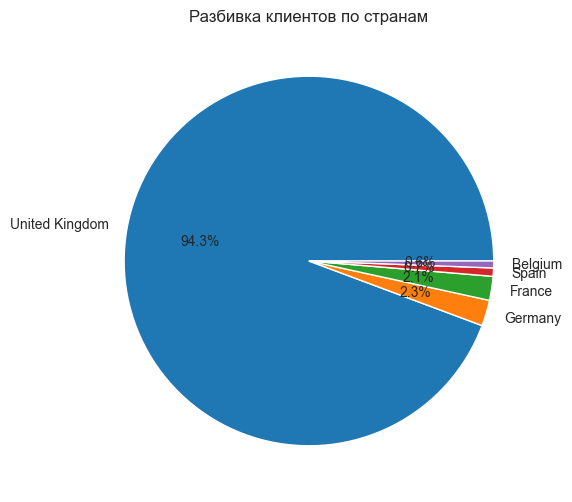

In [90]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.pie(x=customers['CustomerID'],
       labels=customers['Country'],
       autopct='%.1f%%',             # проценты
       startangle=0
)

ax.set_title('Разбивка клиентов по странам')

Мы посмотрели на распределение клиентов в разрезе стран. 
Теперь посмотрим на страны количеству поступающих заказов.

In [7]:
orders_unique = data_cleaned.groupby(by='Country')['InvoiceNo'].nunique().sort_values(ascending=False).reset_index().head(5)

In [8]:
orders_unique

,Country,InvoiceNo
0,United Kingdom,16579
1,Germany,443
2,France,379
3,EIRE,256
4,Belgium,98


Добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**


In [19]:
data = data_cleaned.copy()
data['TotalPrice'] = data['UnitPrice']*(data['Quantity']-data['QuantityCanceled'])
int(data['TotalPrice'].mean())

21

Выделим топ стран, клиенты из которых приносят компании больше всего выручки


In [20]:
country_sum = data.groupby(by='Country')['TotalPrice'].sum().sort_values(ascending=False).reset_index().head(3)

In [21]:
country_sum

,Country,TotalPrice
0,United Kingdom,6797691.44
1,Netherlands,283443.54
2,EIRE,247074.57


Text(0.5, 1.0, 'Cтраны, клиенты из которых приносят компании больше всего выручки')

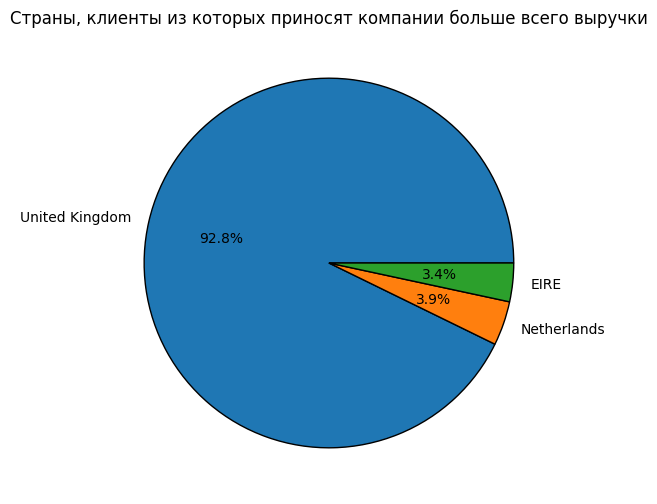

In [12]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.pie(x=country_sum['TotalPrice'],
       labels=country_sum['Country'],
       autopct='%.1f%%',             # проценты
       startangle=0
)

ax.set_title('Cтраны, клиенты из которых приносят компании больше всего выручки')

Теперь займёмся временными характеристиками.


Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391150 entries, 0 to 391149
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   InvoiceNo         391150 non-null  int64  
 1   StockCode         391150 non-null  object 
 2   Description       391150 non-null  object 
 3   Quantity          391150 non-null  int64  
 4   InvoiceDate       391150 non-null  object 
 5   UnitPrice         391150 non-null  float64
 6   CustomerID        391150 non-null  int64  
 7   Country           391150 non-null  object 
 8   QuantityCanceled  391150 non-null  float64
 9   TotalPrice        391150 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 29.8+ MB


In [22]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [23]:
data['Month'] = data['InvoiceDate'].dt.month
data['day_of_week'] = data['InvoiceDate'].dt.day_of_week
data['Hour'] = data['InvoiceDate'].dt.hour

In [24]:
sum_by_month = data.groupby(by='Month')['TotalPrice'].sum().reset_index()

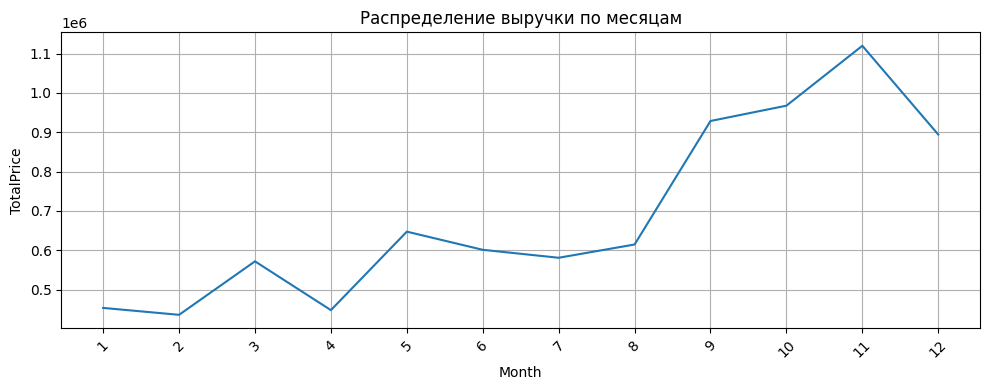

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=sum_by_month, x='Month', y='TotalPrice', ax=ax)
ax.grid()
ax.set_title('Распределение выручки по месяцам')
ax.set_xticks(range(1,13))
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


Больше всего выручки наблюдаем в ноябре. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

Построим визуализацию количества заказов для каждого дня недели.

In [18]:
order_by_day_of_week = data.groupby(by='day_of_week')['InvoiceNo'].nunique().reset_index()

In [19]:
order_by_day_of_week

,day_of_week,InvoiceNo
0,0,2830
1,1,3156
2,2,3436
3,3,4003
4,4,2809
5,6,2168


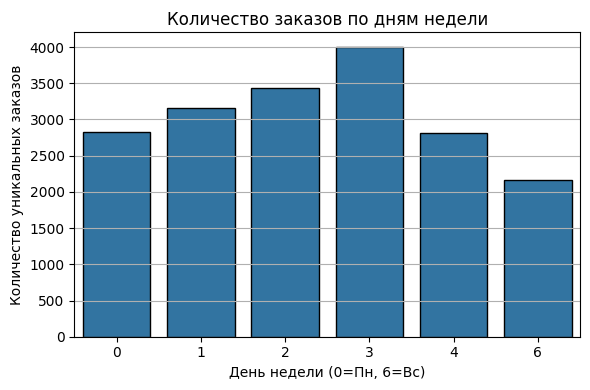

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=order_by_day_of_week, x='day_of_week', y='InvoiceNo', ax=ax)
ax.set_title('Количество заказов по дням недели')
ax.set_xlabel('День недели (0=Пн, 6=Вс)')
ax.set_ylabel('Количество уникальных заказов')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

Согласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

In [21]:
data['day_of_week'].value_counts()

day_of_week
3    78904
2    67769
1    65491
0    63963
6    61084
4    53939
Name: count, dtype: int64

Выделим дату из признака времени совершения транзакции.
Сгруппируем данные по датам и часам совершения транзакции и найдем количество заказов на каждый день-час. Затем найдем среднее количество ежедневно поступающих заказов в каждый из часов.

In [26]:
data['date'] = data['InvoiceDate'].dt.date
# Cгруппируем данные по датам и часам совершения транзакции и найдем количество заказов на каждый день-час.
agg1 = data.groupby(by=['date','Hour'])['InvoiceNo'].nunique().reset_index()
agg1

,date,Hour,InvoiceNo
0,2010-12-01,8,6
1,2010-12-01,9,16
2,2010-12-01,10,11
3,2010-12-01,11,12
4,2010-12-01,12,22
...,...,...,...
2848,2011-12-09,8,4
2849,2011-12-09,9,10
2850,2011-12-09,10,8
2851,2011-12-09,11,6


In [27]:
# найдем среднее количество ежедневно поступающих заказов в каждый из часов
agg2 = agg1.groupby('Hour')['InvoiceNo'].mean().reset_index()
agg2

,Hour,InvoiceNo
0,6,1.000000
1,7,1.260870
2,8,2.715686
3,9,5.488095
4,10,7.273927
5,11,7.440789
6,12,10.222951
7,13,8.685430
8,14,7.478405
9,15,6.714286


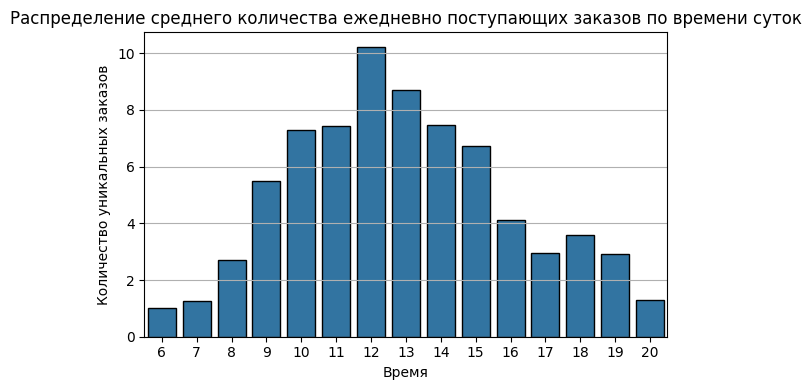

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=agg2, x='Hour', y='InvoiceNo', ax=ax)
ax.set_title('Распределение среднего количества ежедневно поступающих заказов по времени суток')
ax.set_xlabel('Время')
ax.set_ylabel('Количество уникальных заказов')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

Больше всего заказов совершается в дневное время, в интервале от 10 до 15 часов, а с 21 часа до 6 утра (не включительно) заказы не поступают.


## 5. RFM-сегментация клиентов. Снижение размерности методом PCA.

Теперь нужно сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого воспользуемся популярным методом для анализа потребительской ценности под названием RFM. 

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.

Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Создадим RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни.

В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').
* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [216]:
data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,Month,day_of_week,Hour,date,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.3,12,2,8,2010-12-01,373


In [29]:
target_date = pd.to_datetime('2011-12-10 00:00:00')
data['Recency'] = (target_date - data['InvoiceDate']).dt.days

In [30]:
rfm = data.groupby('CustomerID').agg({
    'Recency': 'min',           # Последний заказ (мин Recency)
    'InvoiceNo': 'nunique',     # Количество заказов
    'TotalPrice': 'sum'         # Общая выручка
}).round(2).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,0.00
1,12347,2,7,4310.00
2,12348,75,4,1437.24
3,12349,18,1,1457.55
4,12350,310,1,294.40


In [31]:
rfm = rfm.set_index('CustomerID')
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60


Теперь взглянем на коробчатые диаграммы для каждого из признаков:

In [32]:
boxes = [px.box(rfm, x=column) for column in rfm.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому надо от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [33]:
# 95-й квантиль для Frequency и Monetary
freq_q95 = rfm['Frequency'].quantile(0.95)
mon_q95 = rfm['Monetary'].quantile(0.95)

print(f"Frequency 95%: {freq_q95:.0f}")
print(f"Monetary 95%: {mon_q95:.0f}")

rfm_cleaned = rfm[(rfm['Frequency'] <= freq_q95) & (rfm['Monetary'] <= mon_q95)]

Frequency 95%: 13
Monetary 95%: 5660


После удаления выбросов:


In [34]:
boxes = [px.box(rfm_cleaned, x=column) for column in rfm_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_2.html')
fig.show()

In [35]:
rfm_cleaned.shape

(4044, 3)

## Этап кластеризации.   
Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков.

Построим визуализацию нашего трёхмерного пространства признаков:


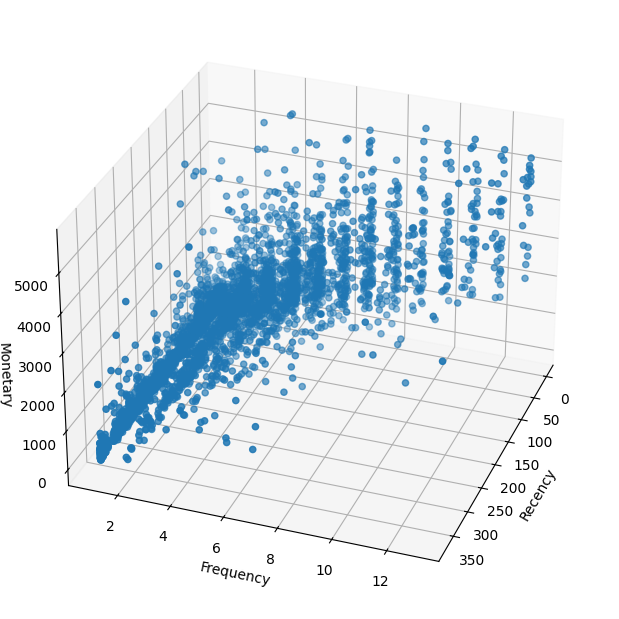

In [36]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_cleaned['Recency'].to_list(), 
    rfm_cleaned['Frequency'].to_list(),
    rfm_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


ничего конкретного увидеть нельзя. Видно что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Попробуем примерить методы снижения размерности.


Начнём с метода главных компонент (PCA). Для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Для удобства обернём эти шаги по предобработке данных в pipeline,в котором будут следующие шаги.
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [38]:
# Создаем pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('PCA', PCA(2))
])
#обучаем алгоритм на наших данных
rfm_pca = pipeline.fit_transform(rfm_cleaned)

# Доступ к атрибутам модели PCA (через имя шага 'pca')
pca_model = pipeline.named_steps['PCA']
print(f"Количество компонент: {pca_model.n_components_}")
print(f"Объясненная дисперсия: {pca_model.explained_variance_ratio_}")

Количество компонент: 2
Объясненная дисперсия: [0.67747053 0.24012744]


Визуализируем пространство главных компонент после декомпозиции:

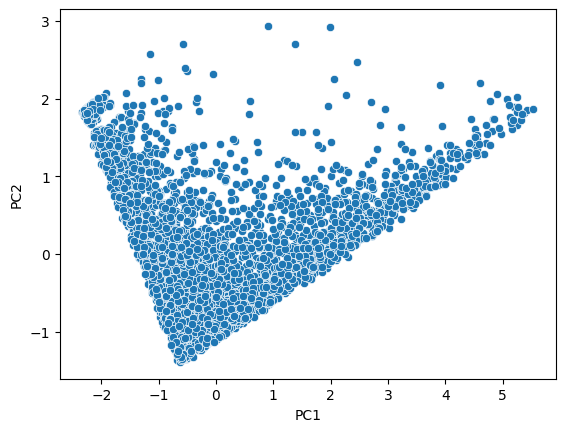

In [39]:
# Создаем DF с именами колонок
df_pca = pd.DataFrame(rfm_pca, columns=['PC1', 'PC2'])
sns.scatterplot(data=df_pca, x='PC1', y='PC2');

Попробуем разделить это пространство главных компонент на сегменты. 

### **Попробуем воспользоваться методом k-means.**

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмем число 42. 

<Axes: xlabel='cluster', ylabel='silhouette'>

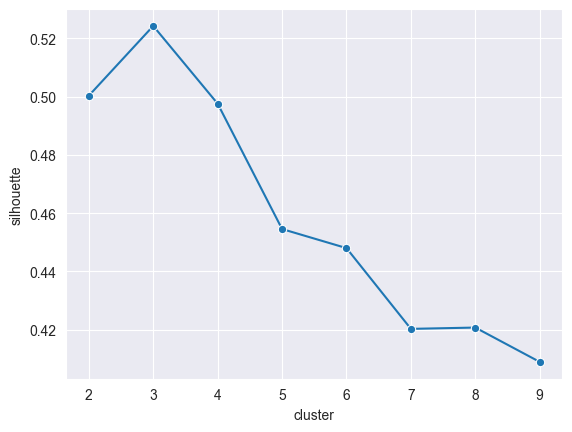

In [41]:
# импортируем метрику силуэт
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

# выберем нужные данные 
X = df_pca

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

На основании этого метода оптимальное количество кластеров = 3.


### **Теперь возьмём EM-алгоритм.**

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.


<Axes: xlabel='cluster', ylabel='silhouette'>

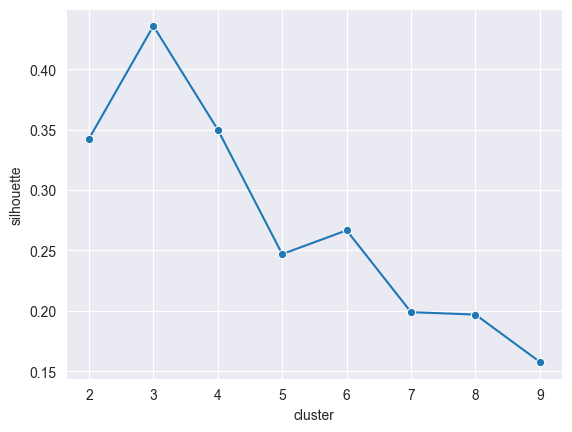

In [42]:
from sklearn.mixture import GaussianMixture

# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    k_means =  GaussianMixture(n_components=cluster_num, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

# выберем нужные данные 
X = df_pca

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

Наибольший коэф. силуэта для 3 кластеров у модели Kmeans (0.52). У EM-алгоритма 0.44. Импользуем эту модель.

In [43]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(df_pca)
df_pca['labels'] = model.labels_
df_pca['labels'].value_counts()

labels
2    2269
0     999
1     776
Name: count, dtype: int64

Визуализируем результаты кластеризации:

Text(0.5, 1.0, 'Кластеры клиентов')

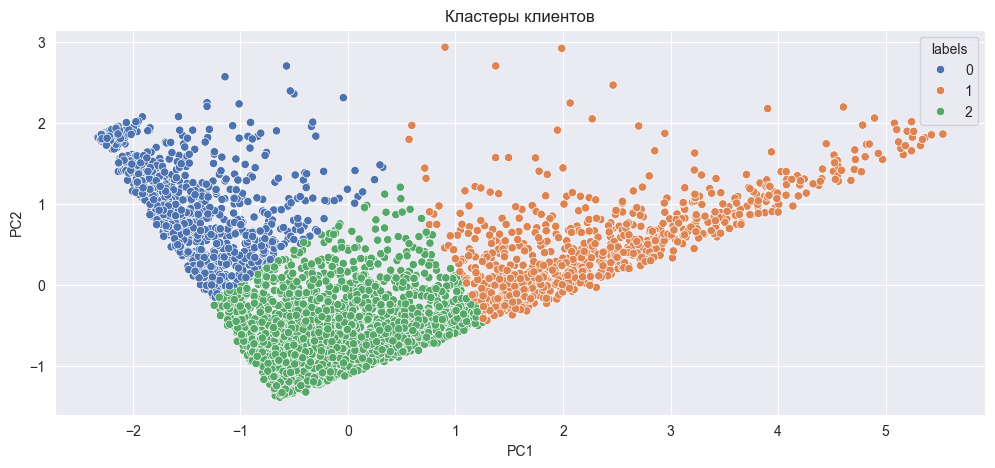

In [44]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df_pca, 
    x='PC1',
    y='PC2', 
    hue='labels',
    palette='deep'
);
plt.title('Кластеры клиентов')

Итак, у нас есть три сегмента клиентов. Попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [45]:
rfm_cleaned['labels'] = model.labels_
rfm_cleaned['labels'].value_counts()

labels
2    2269
0     999
1     776
Name: count, dtype: int64

In [54]:
rfm_grouped = rfm_cleaned.groupby(by='labels').mean()

In [55]:
rfm_grouped

,Recency,Frequency,Monetary
labels,,,
0,253.474474,1.403403,386.277297
1,31.943299,7.068299,2657.746997
2,51.221684,2.329220,660.068947


### Полярная диаграмма
Одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализуем собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [49]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Воспользуемся им.


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 


In [56]:
plot_cluster_profile(rfm_grouped,3)

Можно сделать вывод, что:
* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер 0 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

### 4. RFM-сегментация клиентов. Снижение размерности алгоритмом t-SNE.

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, пытаемся модифицировать полученное решение.

Ранее я производил кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Попробуем и посмотрим, что получится.

Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Посчитаем значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE.

*дивергенция Кульбака-Лейблера* - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. 


In [57]:
# импортируем класс TSNE из модуля manifold библиотеки sklearn
from sklearn.manifold import TSNE

In [59]:
rfm_cleaned = rfm_cleaned.drop(columns='labels',axis=1)

In [61]:
# Создаем pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('TSNE', TSNE(perplexity=50,random_state=100))
])
#обучаем алгоритм на наших данных
rfm_tsne = pipeline.fit_transform(rfm_cleaned)

# Извлекаем объект TSNE из пайплайна
tsne_model = pipeline.named_steps['TSNE']

# Получаем KL-дивергенцию
kl_div = tsne_model.kl_divergence_

print(f"Дивергенция Кульбака-Лейблера: {round(kl_div,2)}")


Дивергенция Кульбака-Лейблера: 0.54


In [62]:
df_tsne = pd.DataFrame(rfm_tsne, columns=['PC1', 'PC2'])

Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


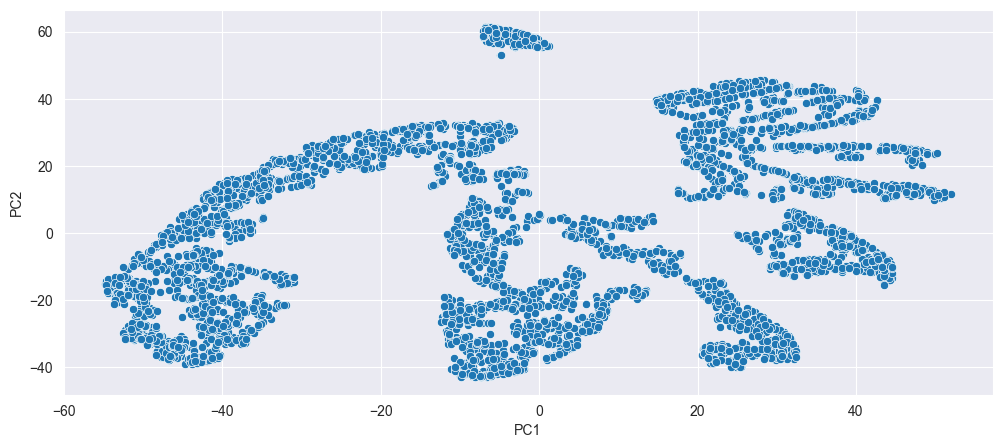

In [63]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_tsne['PC1'], y=df_tsne['PC2']);

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### **Попробуем воспользоваться методом k-means.**

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

<Axes: xlabel='cluster', ylabel='silhouette'>

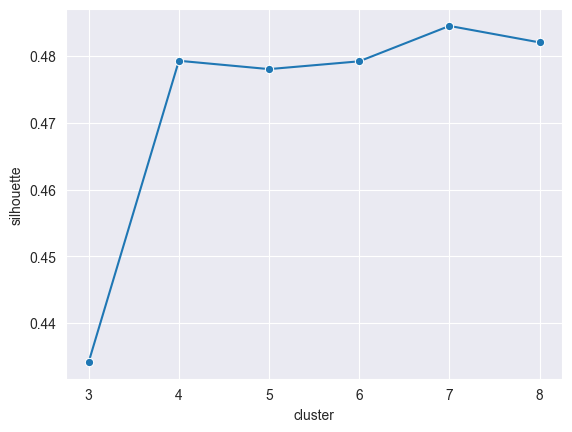

In [64]:
# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

# выберем нужные данные 
X = df_tsne

for cluster_num in range(3, 9):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [48]:
silhouette_df['silhouette'].max()

0.4844949

Судя по полученным результатам, оптимальное количество кластеров 7, макс. значение коэф. силуэта 0.485.

### **Попробуем воспользоваться EM-алгоритом.** 

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

<Axes: xlabel='cluster', ylabel='silhouette'>

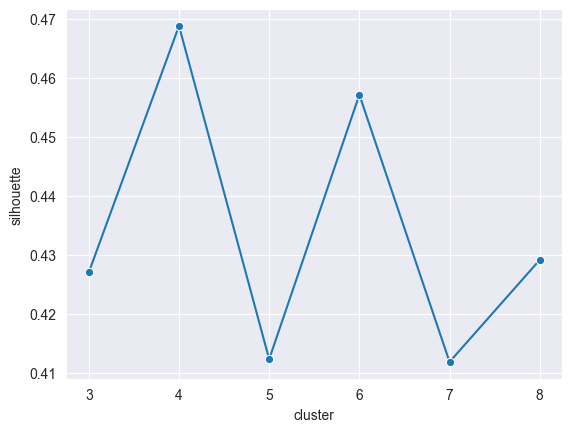

In [49]:
# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    k_means =  GaussianMixture(n_components=cluster_num, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

# выберем нужные данные 
X = df_tsne

for cluster_num in range(3, 9):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [50]:
silhouette_df

,silhouette,cluster
0,0.427071,3
1,0.468827,4
2,0.412347,5
3,0.457162,6
4,0.411883,7
5,0.429173,8


Тут оптимальное количество кластеров 4, макс. значение коэф. силуэта 0.469.

### **Попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).**

Подберем оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 


<Axes: xlabel='cluster', ylabel='silhouette'>

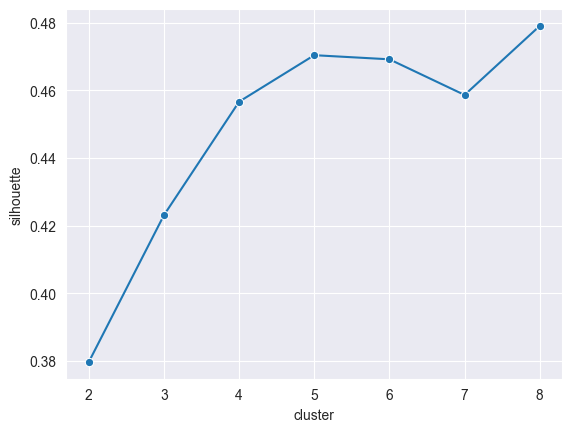

In [65]:
# импортируем  алгоритм
from sklearn.cluster import AgglomerativeClustering

# напишем функцию для определения метрики силуэта
def get_silhouette(cluster_num, X):
    agglomerative_clustering =  AgglomerativeClustering(n_clusters=cluster_num)
    agglomerative_clustering.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, agglomerative_clustering.labels_)
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

# выберем нужные данные 
X = df_tsne

for cluster_num in range(2, 9):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [52]:
silhouette_df

,silhouette,cluster
0,0.379710,2
1,0.423116,3
2,0.456647,4
3,0.470394,5
4,0.469175,6
5,0.458636,7
6,0.479046,8


In [53]:
silhouette_df['silhouette'].max()

0.4790458

Тут оптимальное количество кластеров 8, макс. значение коэф. силуэта 0.479.

Итого, Наибольший кожффициент силуэта на модели K-Means с 7 кластерами. Обучаем эту модель.

In [66]:
model = KMeans(n_clusters=7, random_state=42)
model.fit(df_tsne)
df_tsne['labels'] = model.labels_
df_tsne['labels'].value_counts()

labels
1    914
4    683
0    656
2    543
5    446
6    405
3    397
Name: count, dtype: int64

Визуализируем результаты кластеризации:

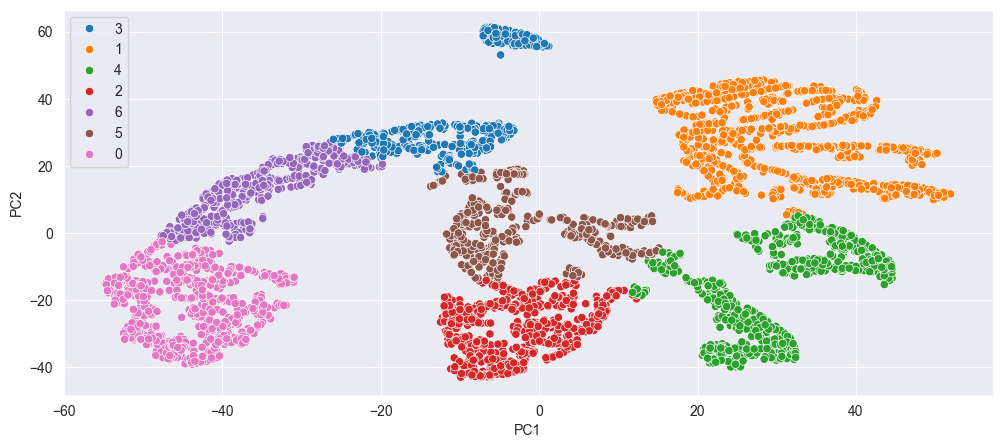

In [67]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_tsne, x='PC1', y='PC2', hue=model.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [68]:
rfm_cleaned['labels'] = model.labels_
rfm_grouped = rfm_cleaned.groupby(by='labels').mean().round()
rfm_grouped

,Recency,Frequency,Monetary
labels,,,
0,46.0,1.0,322.0
1,32.0,7.0,2417.0
2,40.0,2.0,614.0
3,313.0,1.0,261.0
4,40.0,3.0,995.0
5,196.0,2.0,670.0
6,181.0,1.0,273.0


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

In [70]:
plot_cluster_profile(rfm_grouped,7)

Видим, что:
* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 4 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 2 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер 5 соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер 0 соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер 6 соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер 3 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## 7. RFM-кластеризация клиентов. Построение предсказательных моделей.

Мы построили модель кластеризации для части клиентов. Теперь нужносделать предсказание сегмента для клиентов, которые не попали в обучающую выборку.

Нужно помнить, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Т.е. алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Тогда сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_cleaned.drop(columns='labels',axis=1) #очищенная RFM-таблица
y = rfm_cleaned['labels'] #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Т.к. алгоритм t-SNE является нелинейным методом понижения размерности, можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

Поэтому тспользуем ансамблевые алгоритмы. 


### Случайный лес
Начнём со случайного леса. С помощью GridSearchCV организуем перебор параметров случайного леса.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации примем 5.


In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.ensemble import GradientBoostingClassifier

In [76]:
# Задаем сетку параметров
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# Настройка подбора гиперпараметров
RF_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring='accuracy',
    verbose=1
)  

#Выполнение поиска оптимальной конфигурации модели
RF_grid_search.fit(X_train, y_train) 

# Сохраняем лучшую модель
RF_best = RF_grid_search.best_estimator_
print("Наилучшая модель: {}".format(RF_grid_search.best_estimator_))

# Делаем предсказания для лучшей модели
y_train_pred_rf = RF_best.predict(X_train)
y_test_pred_rf = RF_best.predict(X_test)

#Выводим значения метрик чтоб проверить наличие переобучения
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred_rf)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred_rf)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Наилучшая модель: RandomForestClassifier(max_depth=13, n_estimators=200, random_state=42)


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Градиентный бустинг над деревьями решений
С помощью GridSearchCV организуем перебор параметров градиентного бустинга 



In [81]:
# Задаем сетку параметров
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

# Настройка подбора гиперпараметров
GB_grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring='accuracy',
    verbose=1
)  

#Выполнение поиска оптимальной конфигурации модели
GB_grid_search.fit(X_train, y_train) 

# Сохраняем лучшую модель
GB_best = GB_grid_search.best_estimator_
print("Наилучшая модель: {}".format(GB_grid_search.best_estimator_))

# Делаем предсказания для лучшей модели
y_train_pred_gb = GB_best.predict(X_train)
y_test_pred_gb = GB_best.predict(X_test)

#Выводим значения метрик чтоб проверить наличие переобучения
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred_gb)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred_gb)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Наилучшая модель: GradientBoostingClassifier(max_depth=4, n_estimators=200, random_state=42)
Train accuracy: 1.000
Test accuracy: 0.983


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

**Вывод:**

Все этапы задачи выполнены, сформирован RFM-профиль пользователей. На его основании проверено два метода понижения размерности, для каждого метода с помощью коэффициента силуэта подобран оптимальный алгоритм кластеризации и количество кластеров. С помощью полярной диаграммы клиенты разнесены по кластерам.
Построены модели, которые с высокой точностью на основании RFM-профиля новых пользователей могут определять кластер клиента, что позволит повысить качество работы с клиентами.